In [3]:
import numpy as np
import scipy
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua.utils.controlled_circuit import get_controlled_circuit

/home/tinyrick/anaconda3/envs/qcomp/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [4]:
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.aqua.algorithms import QPE
from qiskit.circuit.library import QFT
from qiskit.quantum_info import random_statevector
from qiskit.opflow import X,Y,Z,I,CX
pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

In [5]:
#Operator to gate convertor
def qc(operator):
    qubit_list = list(range(int(np.log(len(operator))/np.log(2))))
    qc = QuantumCircuit(len(qubit_list))
    qc.unitary(operator,qubit_list)
    qc = transpile(qc)
    #gate = qc.to_gate().control(1)
    return qc

In [6]:
trotter_number = 1
H2_op = (5.906709/trotter_number * I ^ I) + \
        (0.218291/trotter_number * Z ^ I) - \
        (6.125/trotter_number * I ^ Z) - \
        (2.143304/trotter_number * X ^ X) - \
        (2.143304/trotter_number * Y ^ Y)
#H2 = H2_op.exp_i()
hamiltonian2 = H2_op.to_matrix()

In [28]:
e,v2 = np.linalg.eig(hamiltonian2)
v2 = np.transpose(v2)
print(e)

[-1.74916122+0.j 13.56257922+0.j  0.        +0.j 11.813418  +0.j]


In [29]:
H2_GC = (5.906709 * I ) - \
        (6.34329 * Z ) - \
        (4.28661 * X )
e,v = np.linalg.eig(H2_GC.to_matrix())
v = np.transpose(v) #to obtain eigen state of Hamiltonian
print(e)

[-1.74916151+0.j 13.56257951+0.j]


# 2 Body GC

In [30]:
betas = [5.9067091,6.34329,4.28661,0]
A = sum(betas)
V_0 = [[1,0],[0,1]]
V_1 = [[-1,0],[0,1]]
V_2 = [[0,-1],[-1,0]]
g_V0 = qc(V_0).to_gate().control(2)
g_V1 = qc(V_1).to_gate().control(2)
g_V2 = qc(V_2).to_gate().control(2)

In [7]:
simulator = Aer.get_backend('qasm_simulator')

In [13]:
# for B Matrix. Ref : resonanceJCP2021
from math import sqrt
B = np.array([[betas[0],sqrt(betas[0]*betas[1]),sqrt(betas[0]*betas[2]),sqrt(betas[0]*betas[3])],
     [sqrt(betas[0]*betas[1]),betas[1],sqrt(betas[2]*betas[1]),sqrt(betas[3]*betas[1])],
     [sqrt(betas[2]*betas[0]),sqrt(betas[2]*betas[1]),betas[2],sqrt(betas[2]*betas[3])],
    [sqrt(betas[0]*betas[3]),sqrt(betas[3]*betas[1]),sqrt(betas[2]*betas[3]),betas[3]]])*2/A - np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
B_g = qc(B).to_gate()
Bdag = np.transpose(B)
Bdag_g = qc(Bdag).to_gate()

ExtensionError: 'Input matrix is not unitary.'

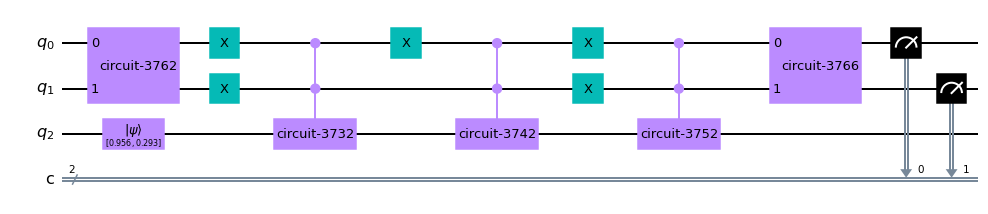

In [33]:
cir = QuantumCircuit(3, 2)
cir.initialize(v[0],2)
cir.append(B_g,[0,1])
cir.x(0)
cir.x(1)
cir.append(g_V0,[0,1,2])
cir.x(0)
cir.append(g_V1,[0,1,2])
cir.x(0)
cir.x(1)
cir.append(g_V2,[0,1,2])
cir.append(Bdag_g,[0,1])
cir.measure([0,1],[0,1])
cir.draw('mpl')

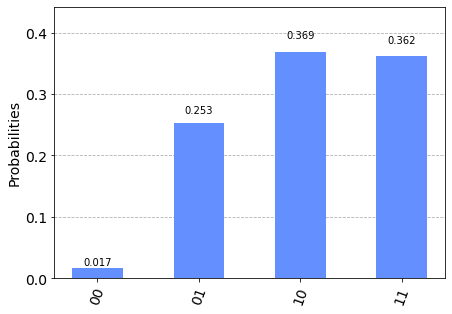

In [34]:
result = execute(cir, backend = simulator, shots = 3000).result()
count = result.get_counts(cir)
display(plot_histogram(count))

Here eigen value for observation where measurement of all ancilla $|0\rangle$ is 
 
 $E = \pm A\sqrt(0.0014) = \pm 0.618743$

## for 2 Body JWT 

In [14]:
m = 3
s = 2
betas = [5.906709,0.218291,6.125,2.143304,2.143304,0,0,0]
A = sum(betas)
V_0 = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
V_1 = [[1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,-1]]
V_2 = [[-1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,1]]
V_3 = [[0,0,0,-1],[0,0,-1,0],[0,-1,0,0],[-1,0,0,0]]
V_4 = [[0,0,0,1],[0,0,-1,0],[0,-1,0,0],[1,0,0,0]]
g_V0 = qc(V_0).to_gate().control(3)
g_V1 = qc(V_1).to_gate().control(3)
g_V2 = qc(V_2).to_gate().control(3)
g_V3 = qc(V_3).to_gate().control(3)
g_V4 = qc(V_4).to_gate().control(3)


In [15]:
# for B
B = np.array([[betas[0],sqrt(betas[0]*betas[1]),sqrt(betas[0]*betas[2]),sqrt(betas[0]*betas[3]),sqrt(betas[0]*betas[4]),sqrt(betas[0]*betas[5]),sqrt(betas[0]*betas[6]),sqrt(betas[0]*betas[7])],
     [sqrt(betas[0]*betas[1]),betas[1],sqrt(betas[2]*betas[1]),sqrt(betas[3]*betas[1]),sqrt(betas[4]*betas[1]),sqrt(betas[5]*betas[1]),sqrt(betas[6]*betas[1]),sqrt(betas[7]*betas[1])],
     [sqrt(betas[2]*betas[0]),sqrt(betas[2]*betas[1]),betas[2],sqrt(betas[2]*betas[3]),sqrt(betas[2]*betas[4]),sqrt(betas[2]*betas[5]),sqrt(betas[2]*betas[6]),sqrt(betas[2]*betas[7])],
    [sqrt(betas[0]*betas[3]),sqrt(betas[3]*betas[1]),sqrt(betas[2]*betas[3]),betas[3],sqrt(betas[3]*betas[4]),sqrt(betas[3]*betas[5]),sqrt(betas[3]*betas[6]),sqrt(betas[3]*betas[7])],
              [sqrt(betas[0]*betas[4]),sqrt(betas[4]*betas[1]),sqrt(betas[2]*betas[4]),sqrt(betas[3]*betas[4]),betas[4],sqrt(betas[4]*betas[5]),sqrt(betas[4]*betas[6]),sqrt(betas[4]*betas[7])],
             [sqrt(betas[0]*betas[5]),sqrt(betas[5]*betas[1]),sqrt(betas[2]*betas[5]),sqrt(betas[3]*betas[5]),sqrt(betas[4]*betas[5]),betas[5],sqrt(betas[5]*betas[6]),sqrt(betas[5]*betas[7])],
              [sqrt(betas[0]*betas[6]),sqrt(betas[6]*betas[1]),sqrt(betas[2]*betas[6]),sqrt(betas[3]*betas[6]),sqrt(betas[4]*betas[6]),sqrt(betas[5]*betas[6]),betas[6],sqrt(betas[6]*betas[7])],
              [sqrt(betas[0]*betas[7]),sqrt(betas[7]*betas[1]),sqrt(betas[2]*betas[7]),sqrt(betas[3]*betas[7]),sqrt(betas[4]*betas[7]),sqrt(betas[5]*betas[7]),sqrt(betas[6]*betas[7]),betas[7]]])*2/A - np.array([[1,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
B_g = qc(B).to_gate()
Bdag = np.transpose(B)
Bdag_g = qc(Bdag).to_gate()

In [49]:
jwt = QuantumCircuit(5,3)
jwt.initialize(v2[1],[3,4])
jwt.append(B_g,[0,1,2])
for i in range(3):
    jwt.x(i)
jwt.append(g_V0,[0,1,2,3,4])
jwt.x(2)
jwt.append(g_V1,[0,1,2,3,4])
jwt.x(1)
jwt.x(2)
jwt.append(g_V2,[0,1,2,3,4])
jwt.x(2)
jwt.append(g_V3,[0,1,2,3,4])
for i in range(3):
    jwt.x(i)
jwt.append(g_V4,[0,1,2,3,4])
jwt.append(Bdag_g,[0,1,2])
jwt.measure([0,1,2],[0,1,2])

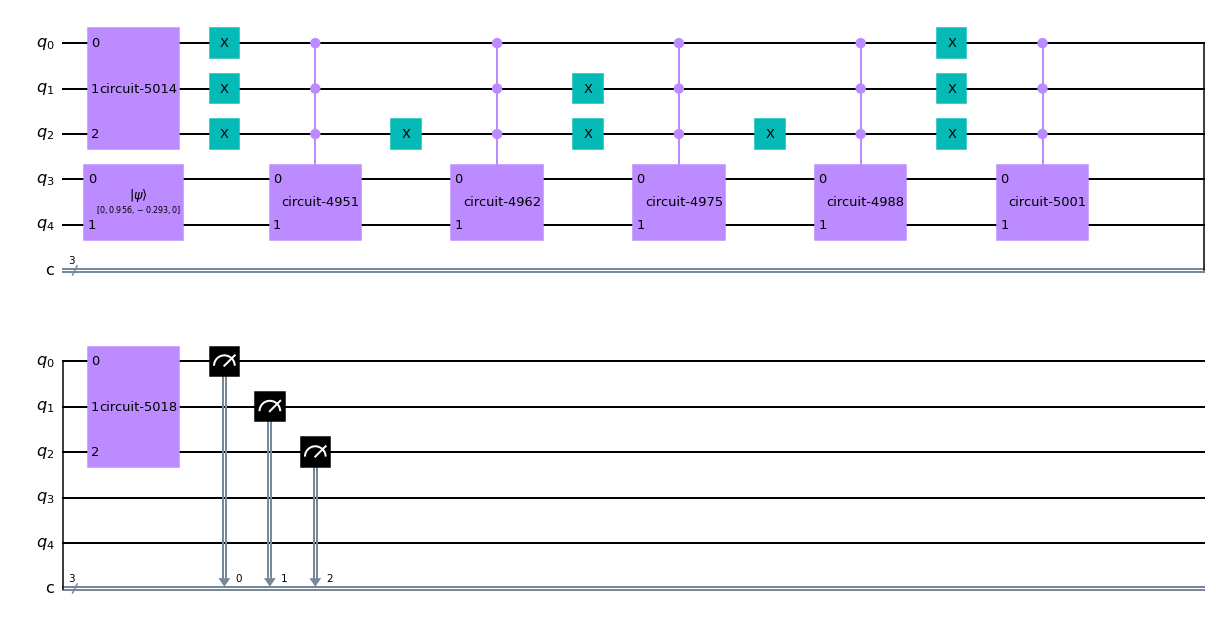

In [50]:
jwt.draw('mpl')

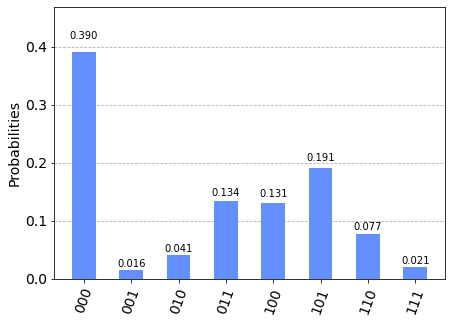

In [51]:
result = execute(jwt, backend = simulator, shots = 3000).result()
count = result.get_counts(jwt)
display(plot_histogram(count))

Here eigen value for observation where measurement of all ancilla $|0\rangle$ is 
 
 $E = \pm A\sqrt(0.39) = \pm 10.3271$

# 3 body gc

In [8]:
H3_op = (5.906709/trotter_number * I ^ I ^ I) + \
        (0.218291/trotter_number * Z ^ I ^ I) - \
        (6.125/trotter_number * I ^ Z ^ I) - \
        (2.143304/trotter_number * X ^ X ^ I) - \
        (2.143304/trotter_number * Y ^ Y ^ I) + \
        (9.625/trotter_number * I ^ I ^ I) - \
        (9.625/trotter_number * I ^ I ^ Z) - \
        (3.913119/trotter_number * I ^ X ^ X) - \
        (3.913119/trotter_number * I ^ Y ^ Y)
H3 = H3_op.exp_i()
hamiltonian3 = H3.to_matrix()


In [21]:
e,v = np.linalg.eig(H3_op.to_matrix())
v = np.transpose(v)
print(len(v[0]))

8


In [16]:
s = 3
m = 3
betas = [0.218291,6.125,2.143304,2.143304,9.625,3.9133119,3.913119,0]
A = sum(betas)
V_0 = [[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,-1,0,0,0],[0,0,0,0,0,-1,0,0],
      [0,0,0,0,0,0,-1,0],[0,0,0,0,0,0,0,-1]]
V_1 = [[-1,0,0,0,0,0,0,0],[0,-1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,-1,0,0,0],[0,0,0,0,0,-1,0,0],
      [0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]]
V_2 = [[0,0,0,0,0,0,-1,0],[0,0,0,0,0,0,0,-1],[0,0,0,0,-1,0,0,0],[0,0,0,0,0,-1,0,0],[0,0,-1,0,0,0,0,0],[0,0,0,-1,0,0,0,0],
      [-1,0,0,0,0,0,0,0],[0,-1,0,0,0,0,0,0]]
V_3 = [[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1],[0,0,0,0,-1,0,0,0],[0,0,0,0,0,-1,0,0],[0,0,-1,0,0,0,0,0],[0,0,0,-1,0,0,0,0],
      [1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0]]
V_4 = [[-1,0,0,0,0,0,0,0],[0,-1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,-1,0,0,0],[0,0,0,0,0,-1,0,0],
      [0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]]
V_5 = [[0,0,0,-1,0,0,0,0],[0,0,-1,0,0,0,0,0],[0,-1,0,0,0,0,0,0],[-1,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,-1],[0,0,0,0,0,0,-1,0],
      [0,0,0,0,0,-1,0,0],[0,0,0,0,-1,0,0,0]]
V_6 = [[0,0,0,1,0,0,0,0],[0,0,-1,0,0,0,0,0],[0,-1,0,0,0,0,0,0],[1,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,1],[0,0,0,0,0,0,-1,0],
      [0,0,0,0,0,-1,0,0],[0,0,0,0,1,0,0,0]]
g_V0 = qc(V_0).to_gate().control(3)
g_V1 = qc(V_1).to_gate().control(3)
g_V2 = qc(V_2).to_gate().control(3)
g_V3 = qc(V_3).to_gate().control(3)
g_V4 = qc(V_4).to_gate().control(3)
g_V5 = qc(V_5).to_gate().control(3)
g_V6 = qc(V_6).to_gate().control(3)

In [17]:
# for B
B = np.array([[betas[0],sqrt(betas[0]*betas[1]),sqrt(betas[0]*betas[2]),sqrt(betas[0]*betas[3]),sqrt(betas[0]*betas[4]),sqrt(betas[0]*betas[5]),sqrt(betas[0]*betas[6]),sqrt(betas[0]*betas[7])],
     [sqrt(betas[0]*betas[1]),betas[1],sqrt(betas[2]*betas[1]),sqrt(betas[3]*betas[1]),sqrt(betas[4]*betas[1]),sqrt(betas[5]*betas[1]),sqrt(betas[6]*betas[1]),sqrt(betas[7]*betas[1])],
     [sqrt(betas[2]*betas[0]),sqrt(betas[2]*betas[1]),betas[2],sqrt(betas[2]*betas[3]),sqrt(betas[2]*betas[4]),sqrt(betas[2]*betas[5]),sqrt(betas[2]*betas[6]),sqrt(betas[2]*betas[7])],
    [sqrt(betas[0]*betas[3]),sqrt(betas[3]*betas[1]),sqrt(betas[2]*betas[3]),betas[3],sqrt(betas[3]*betas[4]),sqrt(betas[3]*betas[5]),sqrt(betas[3]*betas[6]),sqrt(betas[3]*betas[7])],
              [sqrt(betas[0]*betas[4]),sqrt(betas[4]*betas[1]),sqrt(betas[2]*betas[4]),sqrt(betas[3]*betas[4]),betas[4],sqrt(betas[4]*betas[5]),sqrt(betas[4]*betas[6]),sqrt(betas[4]*betas[7])],
             [sqrt(betas[0]*betas[5]),sqrt(betas[5]*betas[1]),sqrt(betas[2]*betas[5]),sqrt(betas[3]*betas[5]),sqrt(betas[4]*betas[5]),betas[5],sqrt(betas[5]*betas[6]),sqrt(betas[5]*betas[7])],
              [sqrt(betas[0]*betas[6]),sqrt(betas[6]*betas[1]),sqrt(betas[2]*betas[6]),sqrt(betas[3]*betas[6]),sqrt(betas[4]*betas[6]),sqrt(betas[5]*betas[6]),betas[6],sqrt(betas[6]*betas[7])],
              [sqrt(betas[0]*betas[7]),sqrt(betas[7]*betas[1]),sqrt(betas[2]*betas[7]),sqrt(betas[3]*betas[7]),sqrt(betas[4]*betas[7]),sqrt(betas[5]*betas[7]),sqrt(betas[6]*betas[7]),betas[7]]])*2/A - np.array([[1,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
B_g = qc(B).to_gate()
Bdag = np.transpose(B)
Bdag_g = qc(Bdag).to_gate()

In [25]:
threegc = QuantumCircuit(6,3)
threegc.initialize(v[0],[3,4,5])
threegc.append(B_g,[0,1,2])
for i in range(3):
    threegc.x(i)
threegc.append(g_V0,[0,1,2,3,4,5])
threegc.x(2)
threegc.append(g_V1,[0,1,2,3,4,5])
threegc.x(1)
threegc.x(2)
threegc.append(g_V2,[0,1,2,3,4,5])
threegc.x(2)
threegc.append(g_V3,[0,1,2,3,4,5])
for i in range(3):
    threegc.x(i)
threegc.append(g_V4,[0,1,2,3,4,5])
threegc.x(2)
threegc.append(g_V5,[0,1,2,3,4,5])
threegc.x([1,2])
threegc.append(g_V6,[0,1,2,3,4,5])
threegc.append(Bdag_g,[0,1,2])
threegc.measure([0,1,2],[0,1,2])


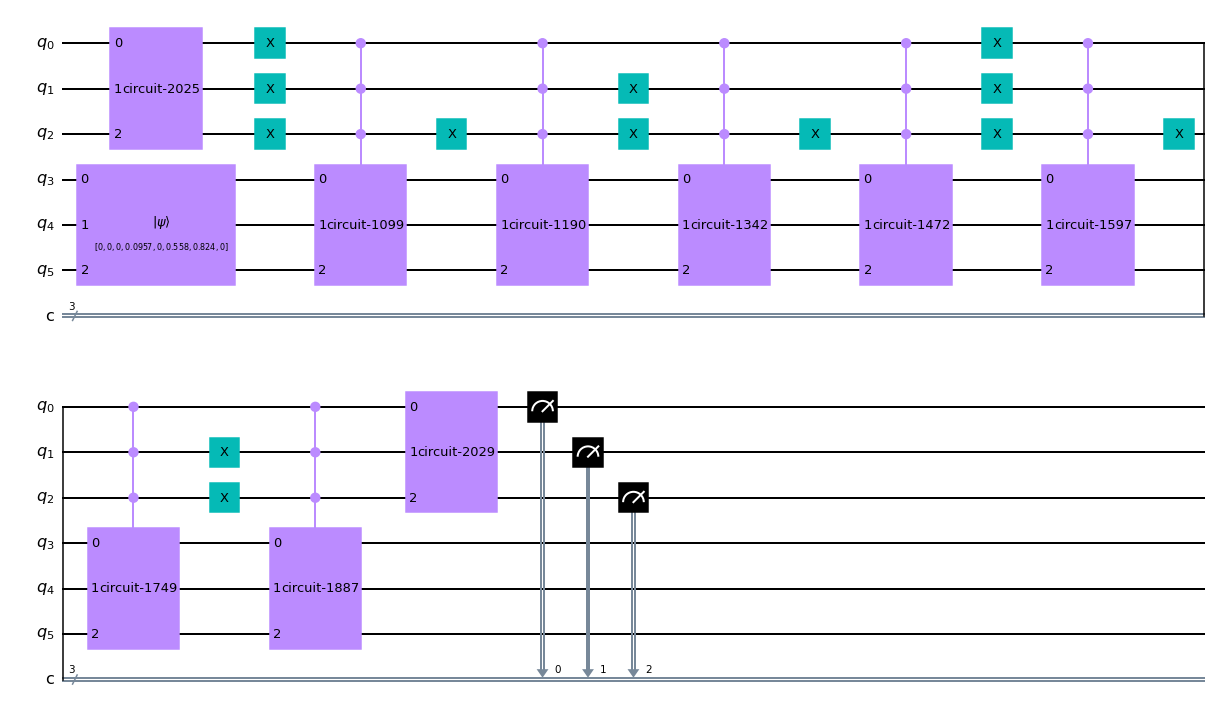

In [26]:
threegc.draw('mpl')

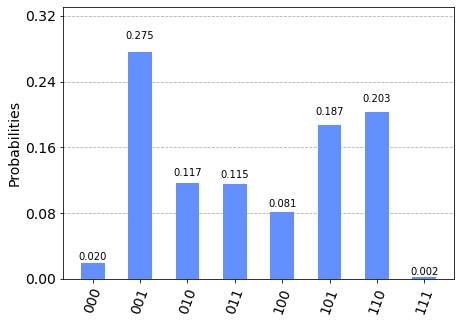

In [27]:
result = execute(threegc, backend = simulator, shots = 3000).result()
count = result.get_counts(threegc)
display(plot_histogram(count))

In [28]:
A

28.0813299

Here eigen value for observation where measurement of all ancilla $|0\rangle$ is 
 
 $E = \pm A\sqrt(0.39) = \pm (3.971+ 5.906709+9.625) = \pm19.50300$  